## Importing Required Libraries

In [3]:
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
import numpy as np
import pandas as pd
import os
import random
import keras
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import load_img
from tensorflow.keras.utils import img_to_array
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report

## Importing Input Dataset

In [5]:
dataset_path="DataSet/COVID-19_Radiography_Dataset"

In [ ]:
c = dataset_path + '/COVID/images' #For Covid
n = dataset_path + '/Normal/images' #For Normal
p = dataset_path + '/Viral Pneumonia/images' #For Pnuemonia 

In [6]:
random.seed(42)
filenames = os.listdir(c) + random.sample(os.listdir(n), 10) + os.listdir(p)

### Classes
* Creating class labels [0 -> Normal, 1 -> Viral Pneumonia, 2 -> COVID]

In [7]:
categories = []
for filename in filenames:
    category = filename.split('-')[0]
    if category == 'COVID':
        categories.append(str(2))
    elif category == 'Viral Pneumonia':
        categories.append(str(1))
    else:
        categories.append(str(0))

## Converting to Dataframe

In [8]:
for i in range(len(filenames)):
    if 'COVID' in filenames[i]:
        filenames[i] = os.path.join(c, filenames[i])
    elif 'Viral Pneumonia' in filenames[i]:
        filenames[i] = os.path.join(p, filenames[i])
    else:
        filenames[i] = os.path.join(n, filenames[i])
    
    
df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

## Printing image from the input dataset

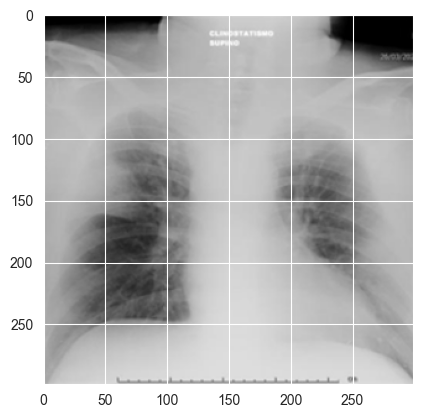

In [12]:
sample = random.choice(df['filename'])
image = load_img(sample)
plt.imshow(image)
plt.show()

## Creating Training, Validation & Testing Dataset from Input

In [13]:
train_data, test_valid_data = train_test_split(df, test_size=0.2, random_state = 42, shuffle=True, stratify=df['category'])
train_data = train_data.reset_index(drop=True)
test_valid_data = test_valid_data.reset_index(drop=True)

In [14]:
test_data, valid_data = train_test_split(test_valid_data, test_size=0.5, random_state = 42,
                                         shuffle=True, stratify=test_valid_data['category'])
test_data = test_data.reset_index(drop=True)
valid_data = valid_data.reset_index(drop=True)

## Data Augmentation

In [15]:
train_data_gen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

In [17]:
train_generator = train_data_gen.flow_from_dataframe(
    train_data, 
    x_col='filename',
    y_col='category',
    target_size=(224,224),
    class_mode='categorical',
    batch_size=32
)

Found 5968 validated image filenames belonging to 3 classes.


In [18]:
valid_data_gen = ImageDataGenerator(rescale=1./255)

valid_generator = valid_data_gen.flow_from_dataframe(
    valid_data, 
    x_col='filename',
    y_col='category',
    target_size=(224,224),
    class_mode='categorical',
    batch_size=32
)

Found 747 validated image filenames belonging to 3 classes.


## Setting up the Xception model

#### Model Architecture

In [19]:
engine = tf.keras.applications.Xception(
        # Freezing the weights of the top layer in the InceptionResNetV2 pre-traiined model
        include_top = False,

        # Use Imagenet weights
        weights = 'imagenet',

        # Define input shape to 224x224x3
        input_shape = (224 , 224 , 3),

    )
    
x = tf.keras.layers.GlobalAveragePooling2D(name = 'avg_pool')(engine.output)
x =tf.keras.layers.Dropout(0.75)(x)
x = tf.keras.layers.BatchNormalization(
                      axis=-1,
                      momentum=0.99,
                      epsilon=0.01,
                      center=True,
                      scale=True,
                      beta_initializer="zeros",
                      gamma_initializer="ones",
                      moving_mean_initializer="zeros",
                      moving_variance_initializer="ones",
                  )(x)
out = tf.keras.layers.Dense(3, activation = 'softmax', name = 'dense_output')(x)


    # Build the Keras model
model = tf.keras.models.Model(inputs = engine.input, outputs = out)
    # Compile the model

model.compile(
        # Set optimizer to Adam(0.0001)
        optimizer = tf.keras.optimizers.Adam(learning_rate= 3e-4),
        # Set loss to crossentropy
        loss = 'categorical_crossentropy',
        # Set metrics to accuracy
        metrics = ['accuracy']
    )


Metal device set to: Apple M1 Pro


2022-11-30 16:08:46.032976: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-11-30 16:08:46.033400: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


83683744/83683744 [==============================] - 205s 2us/step


In [20]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 111, 111, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                             

In [21]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
learning_rate_reduction = keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy',
                                                            patience=2,
                                                            verbose=2,
                                                            factor=0.5,
                                                            min_lr=0.00001)
reduce_lr =  keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=3, min_lr=0.00001)

In [22]:
history = model.fit(train_generator,
                              validation_data=valid_generator, verbose=1, epochs=16,
                       callbacks=[early_stopping, reduce_lr , learning_rate_reduction]
                        )
model.save('Xception.h5')

Epoch 1/16


2022-11-30 16:13:30.163910: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-11-30 16:13:32.305842: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


187/187 [==============================] - ETA: 0s - loss: 0.3296 - accuracy: 0.8737

2022-11-30 16:16:04.907493: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


187/187 [==============================] - 161s 793ms/step - loss: 0.3296 - accuracy: 0.8737 - val_loss: 0.4519 - val_accuracy: 0.8380 - lr: 3.0000e-04
Epoch 2/16
187/187 [==============================] - 144s 770ms/step - loss: 0.1623 - accuracy: 0.9419 - val_loss: 0.1701 - val_accuracy: 0.9371 - lr: 3.0000e-04
Epoch 3/16
187/187 [==============================] - 145s 773ms/step - loss: 0.1252 - accuracy: 0.9558 - val_loss: 0.1541 - val_accuracy: 0.9572 - lr: 3.0000e-04
Epoch 4/16
187/187 [==============================] - 144s 771ms/step - loss: 0.0876 - accuracy: 0.9687 - val_loss: 0.2022 - val_accuracy: 0.9357 - lr: 3.0000e-04
Epoch 5/16
187/187 [==============================] - ETA: 0s - loss: 0.0847 - accuracy: 0.9739
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0001500000071246177.
187/187 [==============================] - 145s 772ms/step - loss: 0.0847 - accuracy: 0.9739 - val_loss: 0.1289 - val_accuracy: 0.9531 - lr: 3.0000e-04
Epoch 6/16
187/187 [===============

# Executing the Xception Model on Testing Dataset

In [23]:
test_set = valid_data_gen.flow_from_dataframe(
    test_data, 
    x_col='filename',
    y_col='category',
    target_size=(224,224),
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 746 validated image filenames belonging to 3 classes.


In [24]:
 model.evaluate(test_set)

24/24 [==============================] - 6s 252ms/step - loss: 0.0612 - accuracy: 0.9812


[0.06115638092160225, 0.9812332987785339]

# Result Metrics

In [25]:
model = keras.models.load_model('SavedModel/Xception.h5')
prob = model.predict(test_set)
predIdxs = np.argmax(prob, axis=1) 


print('\n')
print(classification_report(test_set.labels, predIdxs,target_names = ['Normal','Viral Pneumonia', 'COVID'], digits=5))

2022-11-30 16:53:10.828971: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


24/24 [==============================] - 7s 247ms/step


                 precision    recall  f1-score   support

         Normal    0.97581   0.96800   0.97189       250
Viral Pneumonia    0.99237   0.97015   0.98113       134
          COVID    0.98093   0.99448   0.98765       362

       accuracy                        0.98123       746
      macro avg    0.98303   0.97754   0.98022       746
   weighted avg    0.98127   0.98123   0.98120       746



## Testing model with Random Input

True value is : Normal
1/1 [==============================] - 0s 39ms/step
Prediction is:
Normal


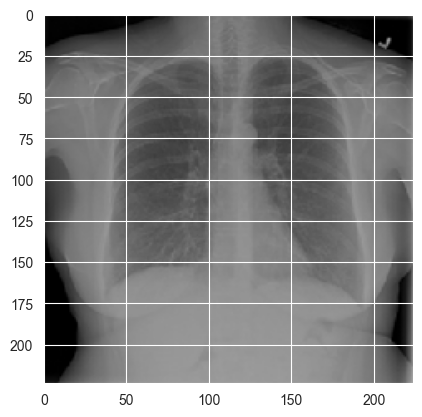

In [108]:
sample = random.choice(test_data['filename'])


category = sample.split('/')[-1].split('-')[0].upper()
true = ''
if category == 'COVID':
    true = 'COVID'
elif category == 'VIRAL PNEUMONIA':
    true = 'Viral Pneumonia'
else:
    true = 'Normal'

print(f'True value is : {true}')
    
image = load_img(sample, target_size=(224, 224))
img = img_to_array(image)/255
img = img.reshape((1, 224, 224, 3))

result = model.predict(img)
result = np.argmax(result, axis=-1)
print('Prediction is:')
if result == 0:
    print("Normal")
elif result == 1:
    print("Viral Pneumonia")
else:
    print("COVID ")
    
    
plt.imshow(image)

In [88]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 111, 111, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                             

In [93]:
len(model.layers)

136